DATA PREPROCESSING

In [50]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

df_total = pd.DataFrame()

#ENTER YOUR USERNAME 

user = 'alilodhi'

# Define the folder containing the CSV files
data_path_1 = f'/Users/{user}/Downloads/UVAmacro-main/post_1/data/dataset1'
data_path_2 = f'/Users/{user}/Downloads/UVAmacro-main/post_1/data/dataset2'

# folder containing exported figures 
figure_path = f'/Users/{user}/Downloads/UVAmacro-main/post_1/figures'


# creating necessary variables 


df_tp = pd.read_csv(f'/Users/{user}/Downloads/UVAmacro-main/post_1/data/dataset1/ACM.csv')

df_tp['Date'] = pd.to_datetime(df_tp['Date'])
df_tp = df_tp[['Date', 'ACMTP10']]
df_tp = df_tp.rename(columns={'ACMTP10': '10y_tp'})

# dataset 2


df_OIS_rates = pd.read_csv(f'{data_path_2}/OIS_swap_rates.csv')



df_OIS_rates.rename(columns={'observation_date': 'Date'}, inplace=True)
df_OIS_rates['Date'] = pd.to_datetime(df_OIS_rates['Date'])




df_total_2 = df_OIS_rates.merge(df_tp, on='Date', how='inner')



df_total_2['butterfly_swap'] = (df_total_2['5yr_OIS_swap'] - (df_total_2['2yr_OIS_swap'] + df_total_2['10yr_OIS_swap']) / 2) * 1000




df_total_2['1y1y'] = (((1 + df_total_2['2yr_OIS_swap'])**2 / (1 + df_total_2['1yr_OIS_swap'])) - 1)

df_total_2['2y1y'] = ((1+df_total_2['3yr_OIS_swap'])**3) / ((1+df_total_2['2yr_OIS_swap'])**2) - 1

df_total_2 = df_total_2.dropna()

df_total_2.sort_values(by='Date', ascending=True, inplace=True)
df_total_2.reset_index(drop=True, inplace=True)

print(df_total_2.Date)






0      1998-01-02
1      1998-01-05
2      1998-01-06
3      1998-01-07
4      1998-01-08
          ...    
6770   2025-02-07
6771   2025-02-10
6772   2025-02-11
6773   2025-02-12
6774   2025-02-13
Name: Date, Length: 6775, dtype: datetime64[ns]


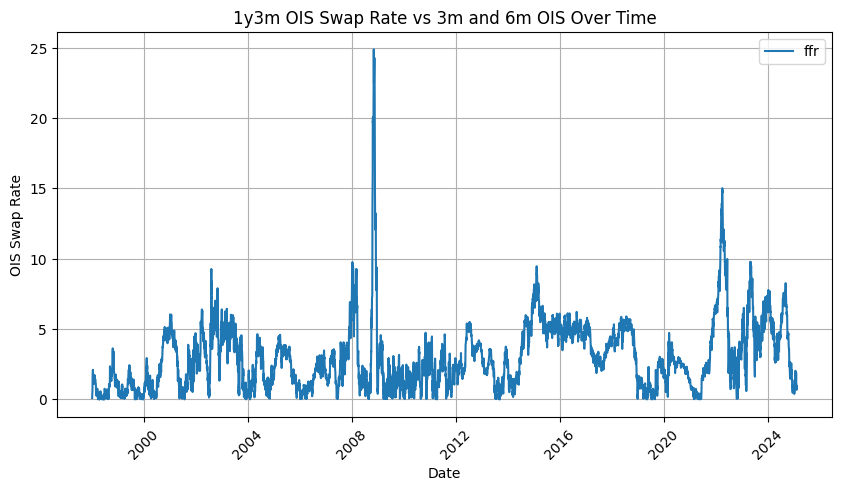

In [23]:
# Compute 1y3m OIS swap rate
df_total_2['1y3m_OIS_swap'] = (( (1 + df_total_2['1yr_OIS_swap']) / 
                                 (1 + df_total_2['6m_OIS_swap'])**(1/2) )**4 ) - 1
df_total_2['3m3m_OIS_swap'] = (( (1 + df_total_2['6m_OIS_swap'])**(1/2) / 
                                 (1 + df_total_2['3m_OIS_swap'])**(1/4) )**4 ) - 1


df_total_2['1y6m_OIS_swap'] = ((1+df_total_2['1yr_OIS_swap'])/(1+df_total_2['6m_OIS_swap'])**0.5)**2 - 1


df_total_2['ffr_curve'] = (df_total_2['1y6m_OIS_swap'] - df_total_2['6m_OIS_swap']) * 1000



df_total_2['ffr_curve'] = df_total_2['ffr_curve'].abs()

df_total_2['aged'] = df_total_2['ffr_curve'].shift(90)


# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(df_total_2['Date'], df_total_2['ffr_curve'], label='ffr')

plt.xlabel("Date")
plt.ylabel("OIS Swap Rate")
plt.title("1y3m OIS Swap Rate vs 3m and 6m OIS Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

df_total_2['5yr_OIS_swap'] = 1000*df_total_2['5yr_OIS_swap']










In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_vol_diff_boxplot(df, date_col, ois_col, aged_col, start_date, end_date):
    """
    Computes realized volatilities (daily and bi-weekly), calculates vol_diff, segments based on z-score distribution, 
    and plots a boxplot of vol_diff for the Full distribution, Bottom 40%, and Bottom 20% z-score groups, 
    conditioned on the move_level being above a threshold.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing relevant columns.
    date_col (str): The name of the date column.
    ois_col (str): The name of the 5-year OIS swap column.
    aged_col (str): The name of the aged variable for z-score calculation.
    move_level_col (str): The name of the move_level column.
    move_level_threshold (float): The threshold for filtering move_level.
    start_date (str): The start date for filtering observations (format: 'YYYY-MM-DD').

    Returns:
    None (Displays a boxplot)
    """

    df = df.copy()

    # Convert date column to datetime if not already
    df[date_col] = pd.to_datetime(df[date_col])

    # Filter data for the specified date range
    df = df[df[date_col] >= pd.to_datetime(start_date)]
    df = df[df[date_col] <= pd.to_datetime(end_date)]

    # Apply condition on move_level
    
    # Compute rolling realized volatilities
    df['RV_daily'] = df[ois_col].rolling(90).std()
    df['RV_biweekly'] = df[ois_col].rolling(90).apply(lambda x: np.std(x[::15]), raw=True) / np.sqrt(15)

    # Compute the difference in realized volatility
    df['vol_diff'] = df['RV_biweekly'] - df['RV_daily']

    # Compute z-score for 'aged' variable over a 252-day window
    df['rolling_mean'] = df[aged_col].rolling(252).mean()
    df['rolling_std'] = df[aged_col].rolling(252).std()
    df['z_score'] = (df[aged_col] - df['rolling_mean']) / df['rolling_std']

    # Compute quantiles for z-score segmentation
    quantiles = df['z_score'].quantile([0.2, 0.3, 0.4, 1])

    # Assign segmentation categories using double storage
    df.loc[df['z_score'] <= quantiles[1], 'z_score_segment'] = 'Full distribution'
    df.loc[df['z_score'] <= quantiles[0.3], 'z_score_segment'] += ', Bottom 30%'
    df.loc[df['z_score'] <= quantiles[0.2], 'z_score_segment'] += ', Bottom 20%'

    # Create a boxplot for vol_diff grouped by z-score segments
    plt.figure(figsize=(8, 6))

    boxprops = dict(showfliers=False, showmeans=True, meanline=True)  # Hide outliers, show mean line

    df.boxplot(column='vol_diff', by='z_score_segment', patch_artist=True, **boxprops)
    
    plt.title('Distribution of vol_diff by z_score Segment')
    plt.xlabel('Z-score Segment')
    plt.ylabel('Volatility Difference (vol_diff)')
    plt.suptitle('')  # Remove default title from boxplot
    plt.show()

# Example usage: Apply the function with a threshold on `move_level`
plot_vol_diff_boxplot(df_total_2, 'Date', '5yr_OIS_swap', 'aged', '2023-01-01', '2024-11-20')




NameError: name 'df_total_2' is not defined